In [59]:
from printer_anomaly_detection.model.cae import CAE
from pathlib import Path
import tensorflow as tf
from printer_anomaly_detection.dataset.audio import get_normalization_stats
from printer_anomaly_detection.dataset.audio import Split, load_audio_dataset_split
import matplotlib.pyplot as plt
import matplotlib as mpl

tf.config.set_visible_devices([], 'GPU')

# set dpi of all plots
mpl.rcParams['figure.dpi'] = 200

In [12]:
reconstruction_loss = tf.keras.losses.mae

In [83]:
def histogram_reconstruction_loss(reconstruction_loss, title, ylim=(0, 1e5), xlim=(0, 3.0)):
    plt.figure()
    plt.hist(reconstruction_loss, bins=20, log=True)
    plt.xlabel('Reconstruction Loss')
    plt.ylabel('Count')
    #fixed xlimit
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.title(title)

In [2]:
project_path = Path('../../../../')
dataset_path = project_path / 'datasets' / 'prints'

original_dataset = load_audio_dataset_split(dataset_path, 'original', Split.TEST, window_size=256, step_size=8, scale=True, shuffle_data=True)
original_dataset = list(original_dataset.take(5000))
exhaust_dataset = load_audio_dataset_split(dataset_path, 'exhaust', Split.TEST, window_size=256, step_size=64, scale=True, shuffle_data=True)
exhaust_dataset = list(exhaust_dataset.take(5000))
directdrive_dataset = load_audio_dataset_split(dataset_path, 'direct_drive', Split.TEST, window_size=256, step_size=32, scale=True, shuffle_data=True)
directdrive_dataset = list(directdrive_dataset.take(5000))

2023-06-27 19:01:23.370328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/y2g/projects/personal/printer-anomaly-detection/src/printer_anomaly_detection/dataset/audio.py:73: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(path.as_posix())
/home/y2g/projects/personal/printer-anomaly-detection/.venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
2023-06-27 19:01:32.659059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not in

In [3]:
print('Original dataset size: {}'.format(len(original_dataset)))
print('Exhaust dataset size: {}'.format(len(exhaust_dataset)))
print('Direct drive dataset size: {}'.format(len(directdrive_dataset)))

Original dataset size: 5000
Exhaust dataset size: 5000
Direct drive dataset size: 5000


# Original -> Exhaust

In [4]:
from printer_anomaly_detection.model.cae import CAE
from pathlib import Path
import tensorflow as tf
from printer_anomaly_detection.dataset.audio import get_normalization_stats

mean, var, min, max = get_normalization_stats(dataset_path, 'original')
#model = CAE(latent_dim=256, activation='relu', renorm=False, mean=mean, var=var)
#model.load_weights(project_path / 'checkpoints' / '2023-06-22T22:07:01-test-31d7553'/ 'test-31d7553.231-0.3521.h5')
model = CAE(latent_dim=256, activation='relu', renorm=False, mean=mean, var=var, last_activation='tanh')
model.load_weights(project_path / 'checkpoints' / '2023-06-23T16:52:11-exhaust_test-0f73462'/ 'exhaust_test-0f73462.250-0.0672.h5')

## Encoding-Decoding Original

In [5]:
original_old_dataset = load_audio_dataset_split(dataset_path, 'original', Split.TEST, window_size=256, step_size=8, scale=False, shuffle_data=True)
original_old_dataset = list(original_old_dataset.take(5000))
print('Original old dataset size: {}'.format(len(original_old_dataset)))

2023-06-27 19:02:07.064495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Original old dataset size: 5000


In [6]:
predicted_original = model.predict(tf.convert_to_tensor(original_old_dataset))

157/157 [==============================] - 17s 105ms/step


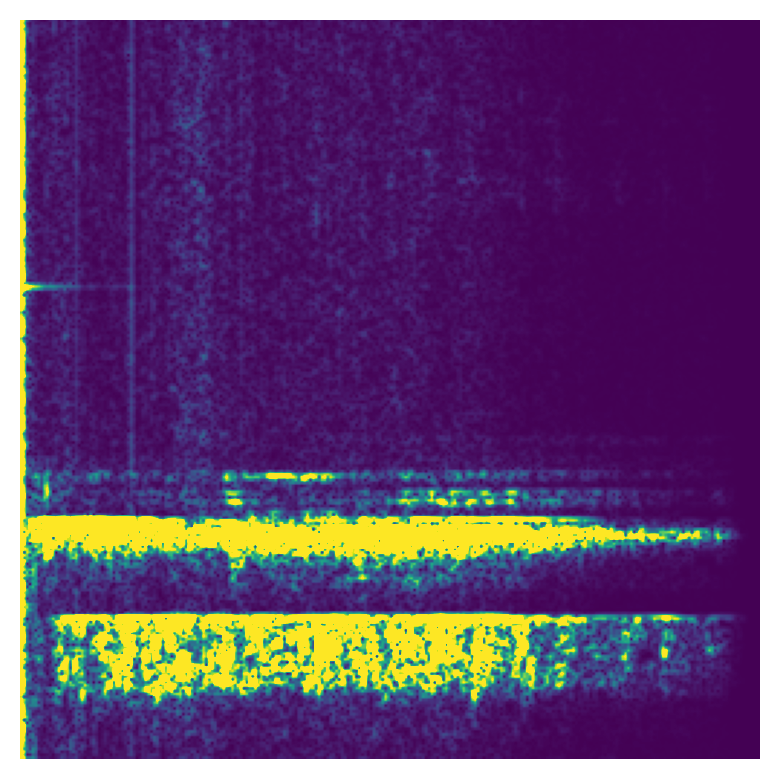

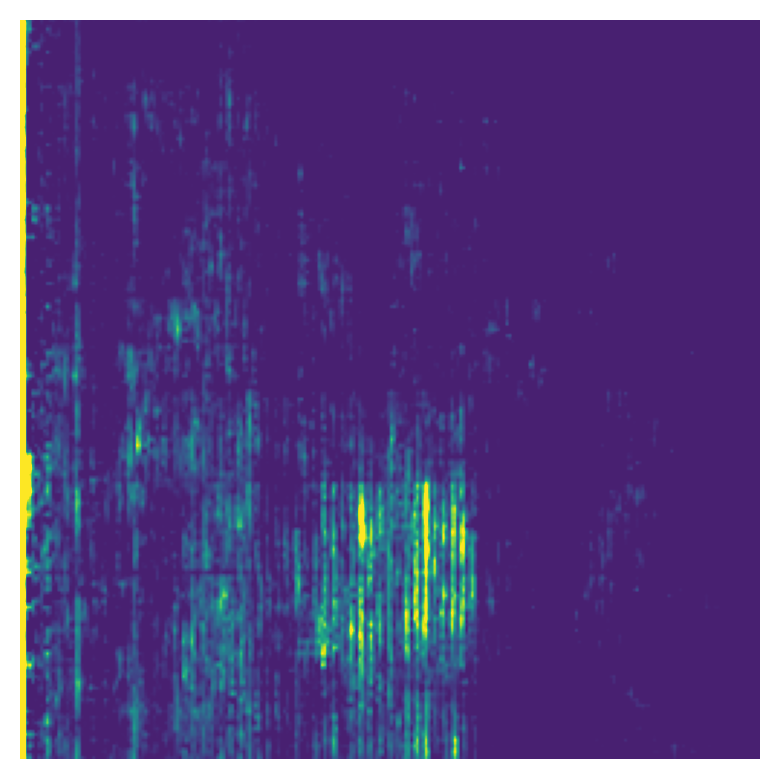

In [60]:
plt.figure()
plt.axis('off')
plt.imshow(original_old_dataset[100], norm=mpl.colors.NoNorm())
plt.figure()
plt.axis('off')
plt.imshow(predicted_original[100], norm=mpl.colors.NoNorm())

In [36]:
def l2norm(y_true,y_pred,axis):
    return tf.reduce_mean(tf.square(y_true - y_pred), axis=axis)

In [37]:
original_reconstruction_loss = l2norm(tf.reshape(tf.convert_to_tensor(original_old_dataset), (5000,256,256)), tf.reshape(predicted_original, (5000,256,256)), axis=(1,2))

/tmp/ipykernel_238078/648765701.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1e5)


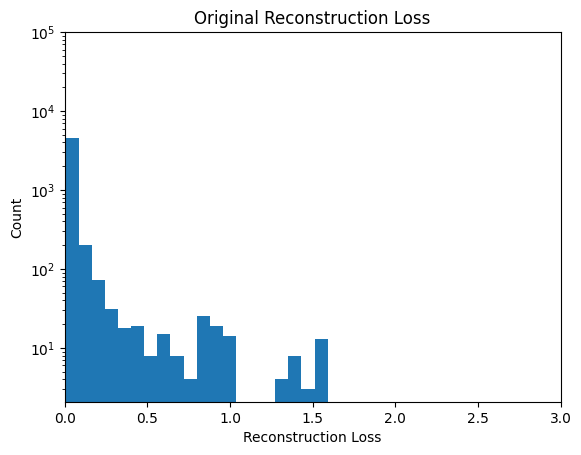

In [50]:

histogram_reconstruction_loss(original_reconstruction_loss, 'Original Reconstruction Loss')

In [8]:
exhaust_old_dataset = load_audio_dataset_split(dataset_path, 'exhaust', Split.TRAIN, window_size=256, step_size=32, scale=False, shuffle_data=True)
exhaust_old_dataset = list(exhaust_old_dataset.take(5000))
print('Exhaust old dataset size: {}'.format(len(exhaust_old_dataset)))

2023-06-27 19:02:28.307463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
/home/y2g/projects/personal/printer-anomaly-detection/src/printer_anomaly_detection/dataset/audio.py:73: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, _ = librosa.load(path.as_posix())
/home/y2g/projects/personal/printer-anomaly-detection/.venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Exhaust old dataset size: 5000


In [9]:
predicted = model.predict(tf.convert_to_tensor(exhaust_old_dataset))

157/157 [==============================] - 16s 104ms/step


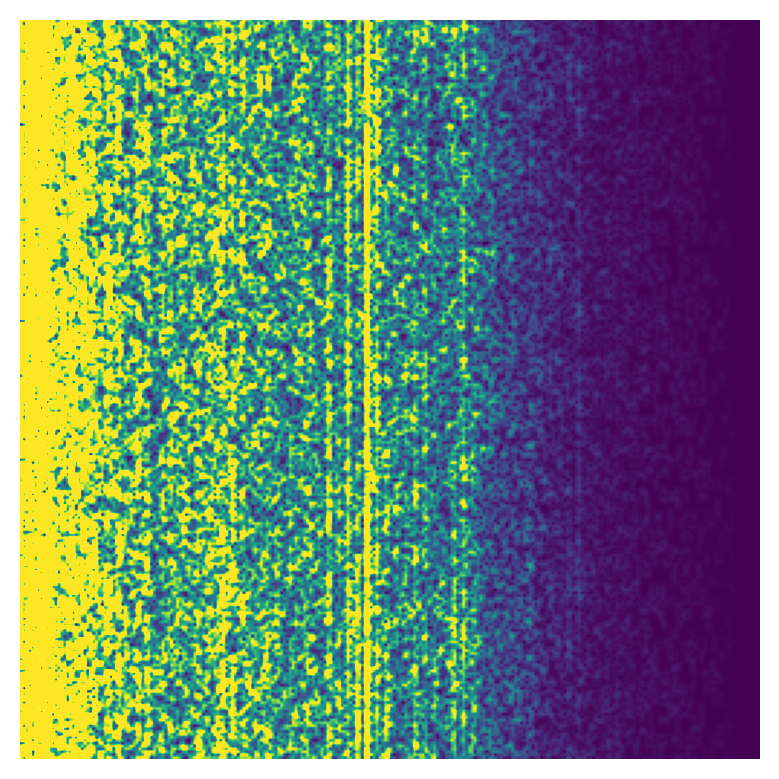

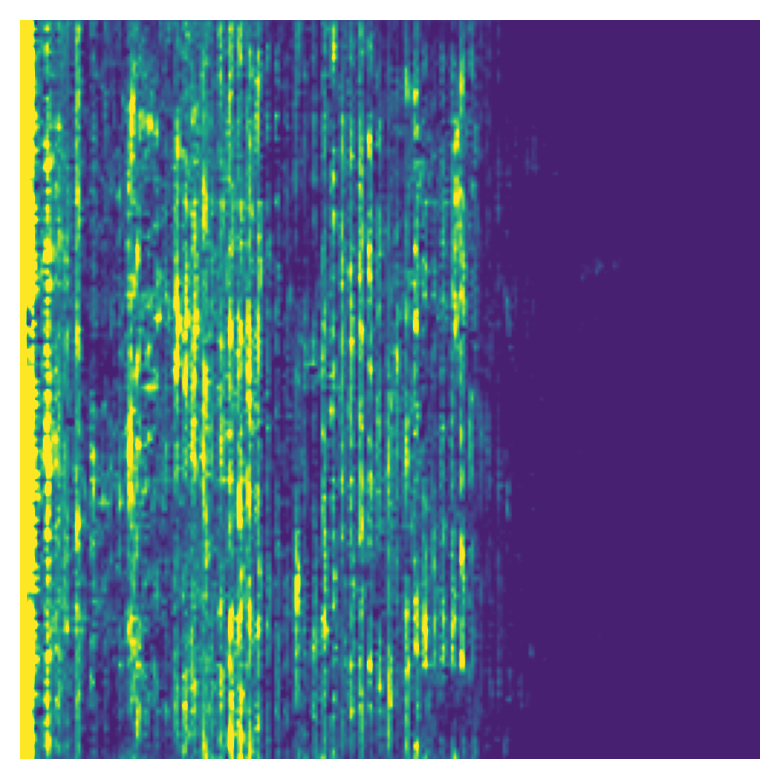

In [61]:
plt.figure()
plt.axis('off')
plt.imshow(exhaust_old_dataset[100], norm=mpl.colors.NoNorm())
plt.figure()
plt.axis('off')
plt.imshow(predicted[100], norm=mpl.colors.NoNorm())

/tmp/ipykernel_238078/648765701.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1e5)


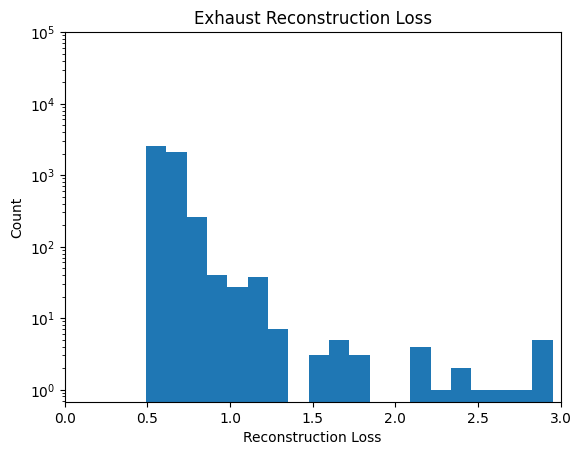

In [51]:
exhaust_reconstruction_loss = l2norm(tf.reshape(tf.convert_to_tensor(exhaust_old_dataset), (5000,256,256)), tf.reshape(predicted, (5000,256,256)), axis=(1,2))

histogram_reconstruction_loss(exhaust_reconstruction_loss, 'Exhaust Reconstruction Loss')

# Exhaust -> Direct-Drive

In [73]:
from printer_anomaly_detection.model.cae import CAE
from pathlib import Path
import tensorflow as tf
from printer_anomaly_detection.dataset.audio import get_normalization_stats

model = CAE(latent_dim=256, activation='relu', renorm=False)
model.load_weights(project_path / 'checkpoints' / '2023-06-25T19:42:02-real_exhaust_test-187bd95'/ 'real_exhaust_test-187bd95.250-0.0260.h5')

In [74]:
predicted_exhaust = model.predict(tf.convert_to_tensor(exhaust_dataset))

157/157 [==============================] - 16s 103ms/step


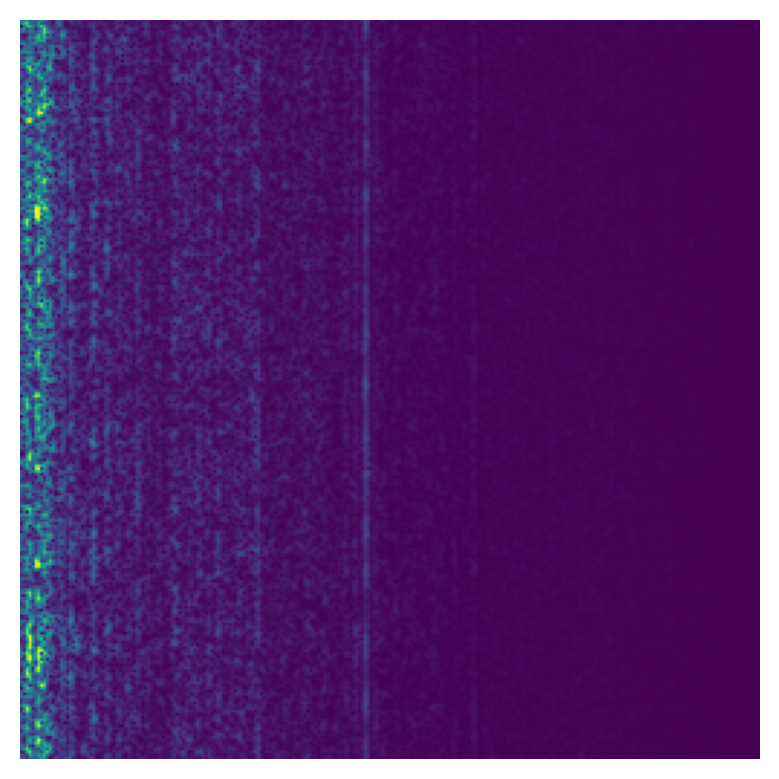

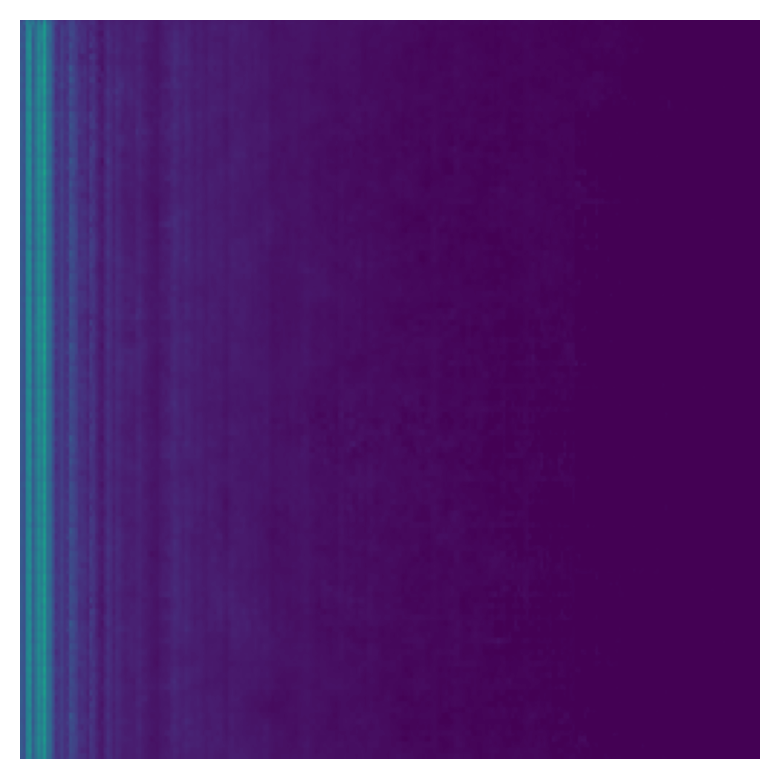

In [80]:
plt.figure()
plt.axis('off')
plt.imshow(exhaust_dataset[3000], norm=mpl.colors.NoNorm())
plt.figure()
plt.axis('off')
plt.imshow(predicted_exhaust[3000], norm=mpl.colors.NoNorm())

/tmp/ipykernel_238078/34227292.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


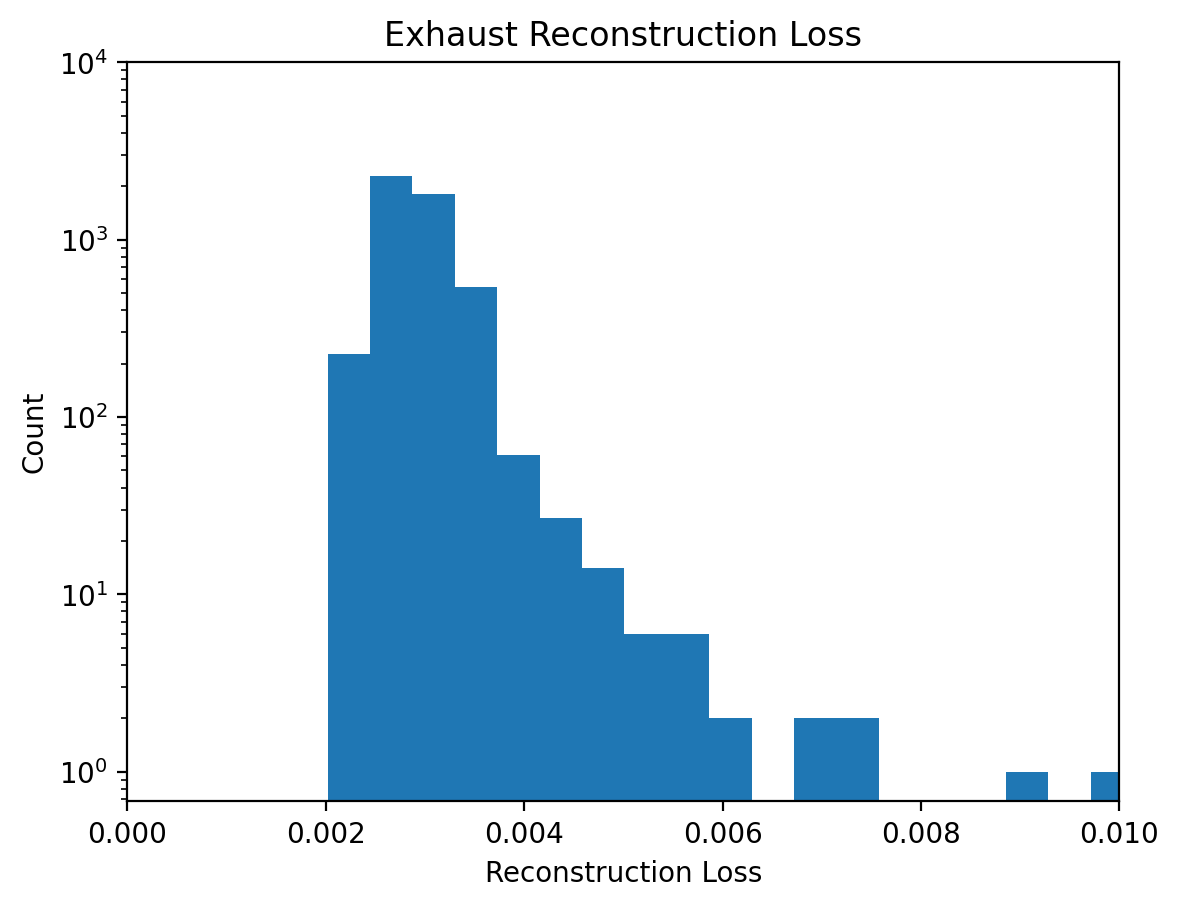

In [95]:
reconstruction_loss_exhaust = l2norm(tf.reshape(tf.convert_to_tensor(exhaust_dataset), (5000,256,256)), tf.reshape(predicted_exhaust, (5000,256,256)), axis=(1,2))

histogram_reconstruction_loss(reconstruction_loss_exhaust, 'Exhaust Reconstruction Loss', xlim=(0, 0.01), ylim=(0,1e4))

In [89]:
predicted_directdrive = model.predict(tf.convert_to_tensor(directdrive_dataset))

157/157 [==============================] - 16s 104ms/step


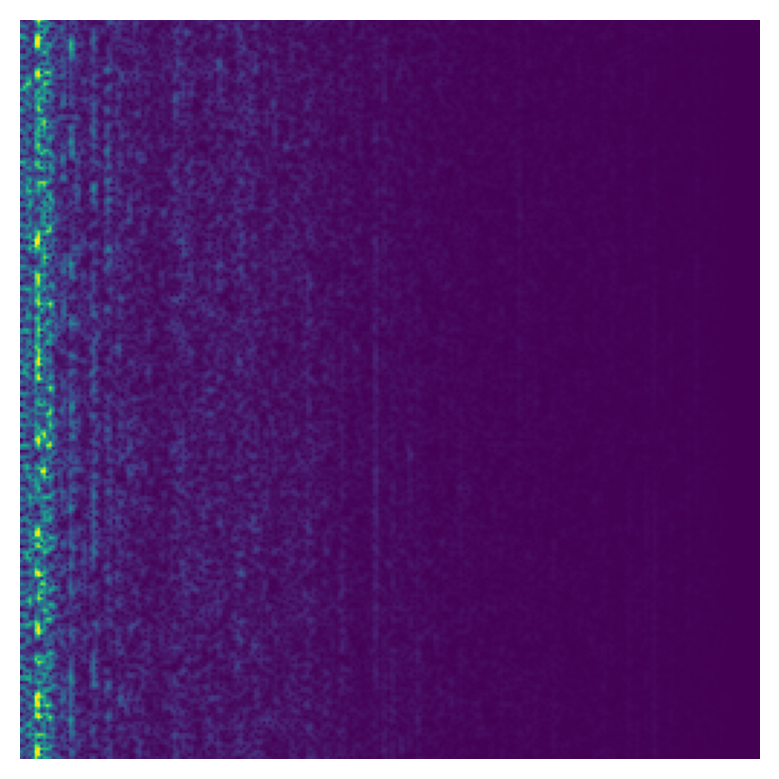

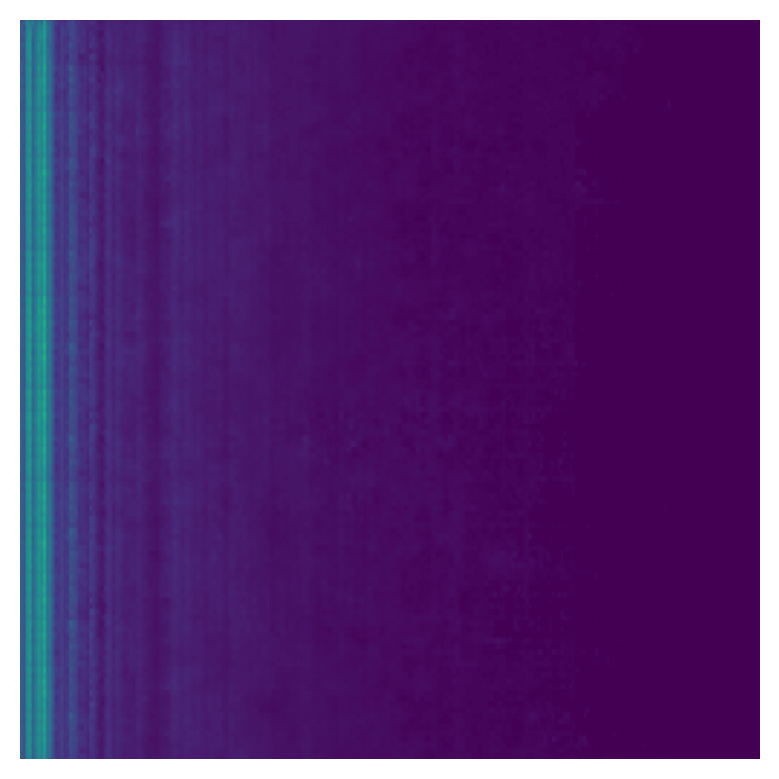

In [91]:
plt.figure()
plt.axis('off')
plt.imshow(directdrive_dataset[1000], norm=mpl.colors.NoNorm())
plt.figure()
plt.axis('off')
plt.imshow(predicted_directdrive[1000], norm=mpl.colors.NoNorm())

/tmp/ipykernel_238078/34227292.py:10: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ylim)


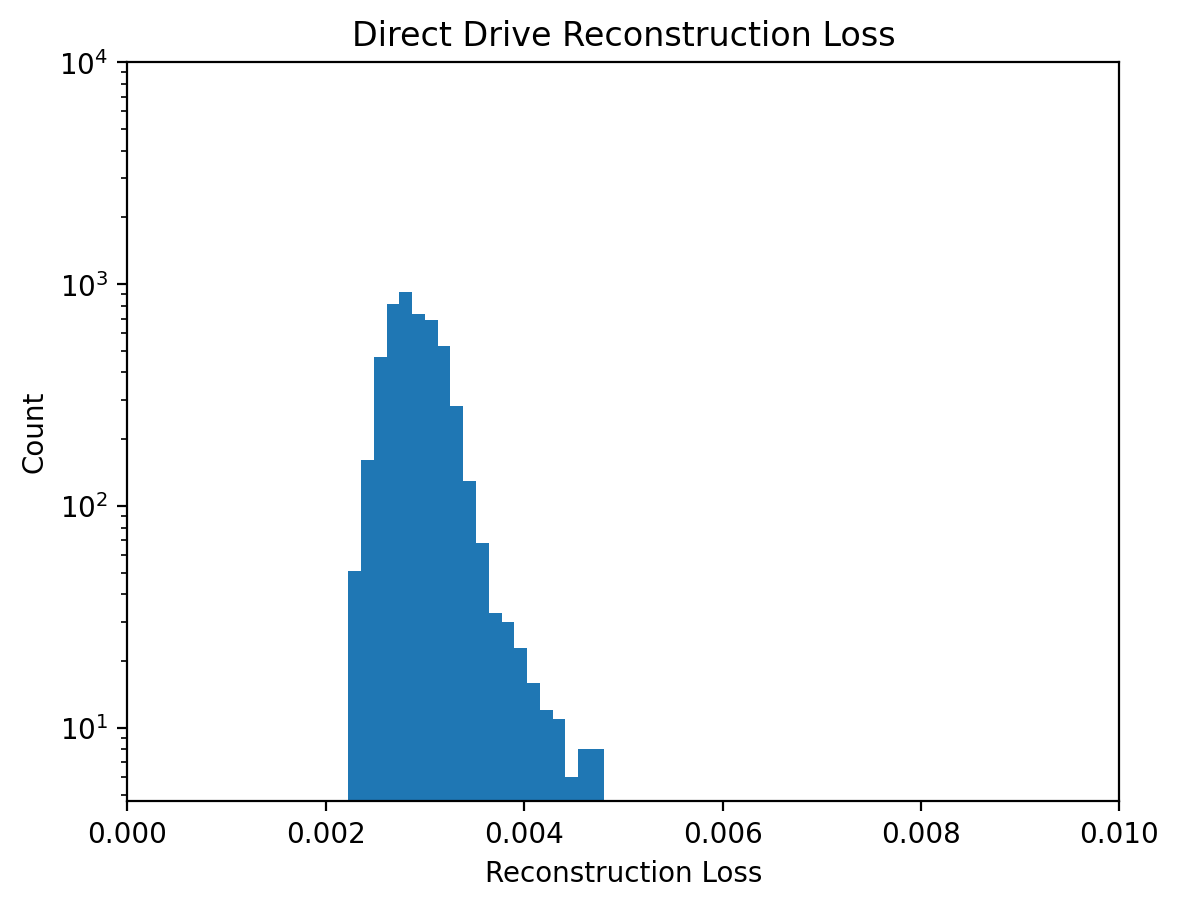

In [96]:
reconstruction_loss_directdrive = l2norm(tf.reshape(tf.convert_to_tensor(directdrive_dataset), (5000,256,256)), tf.reshape(predicted_directdrive, (5000,256,256)), axis=(1,2))

histogram_reconstruction_loss(reconstruction_loss_directdrive, 'Direct Drive Reconstruction Loss', xlim=(0, 0.01), ylim=(0,1e4))